# BARRA's Risk Model
## Dynamics of Price
Based on the celebrated APT model and Berra's risk model, I proposed the stock forecasting model as the following expression.

$$r_{i}(t) = \alpha(t) + \sum_{k=1}^K \beta_{ik}(t) F_{ik}(t)$$

The factor exposures $\beta$ is assumed to be known in this script, and valuated as the rescaled (normalized) factor values. In BARRA's risk model, we use cross-sectional linear regression to train factor returns and excess returns. However the variables vary from time to time. A regular strategy to summarize the historical parameters would be simple average or weighted average with exponential decay. For model calibration, there are three ways to handle it: cross-sectional regression, gradient descend scheme for the loss function, and kalman filter. In this notebook, I mainly focus on the former two techniques.
## Model Definition

In [4]:
import pandas as pd
import statsmodels.api as sm
from statsmodels import regression,stats
import itertools
from pykalman import KalmanFilter
idx = pd.IndexSlice

class MultiFactorModel:
    def __init__(self, price_df, equity_df, benchmark_df, factor_list, universe):
        self.price_df = price_df
        self.equity_df = equity_df
        self.benchmark_df = benchmark_df
        self.factor_list = factor_list
        self.universe = universe
        self.valid_universe = None
        self.subset = None
        
        # z-score in universe
        tmp_equity_df = self.calculate_subset_df(self.equity_df,self.universe)
        tmp_equity_df = tmp_equity_df[factor_list].fillna(0) # TODO: fill or drop??
        self.factor_zscore = (tmp_equity_df - tmp_equity_df.groupby(level='date').mean())/tmp_equity_df.groupby(level='date').std()
        
        # valide_universe
        self.valid_universe = self.calculate_valid_universe()
        self.valid_factor_zscore = self.factor_zscore.loc[idx[:,self.valid_universe],:]


    def calculate_valid_universe(self):
        valid_universe = set(self.universe)

        for date,group in self.factor_zscore.groupby(level=0):
            size = group.shape[0]
            new_set = set(group.loc[idx[:,valid_universe],:].index.get_level_values(1).values)
            if(new_set<valid_universe):
                valid_universe = new_set
        # self.valid_universe = valid_universe        
        return valid_universe

    def calculate_subset_df(self,df,subset):
        return df.loc[idx[:,subset],:]
        
    def calculate_portfolio_risk(self,hp):
        if(~hasattr(self,'V') or self.V==None):
            self.cross_section_regression()
        sigmap = np.sqrt(np.dot(np.dot(hp.T,self.V),hp))
        MCTR = np.dot(self.V,hp)/sigmap
        return self.V, sigmap, MCTR
        
    def time_series_regression(self):
        ts_factor_zscore = sm.add_constant(self.factor_zscore)
        Y = [self.equity_df.xs(asset,level=1)['return'] for asset in self.valid_universe]
        X = [ts_factor_zscore.xs(asset,level=1)[factor_list+['const']] for asset in self.valid_universe]
        reg_results = [regression.linear_model.OLS(y,x).fit().params for y,x in zip(Y,X) if not(x.empty or y.empty)]
        indices = [asset for y, x, asset in zip(Y, X, self.valid_universe) if not(x.empty or y.empty)]
        ts_result_df = pd.DataFrame(reg_results, index=indices)
        return ts_result_df
    
#     def regression(self,tau):
#         Xtik = self.factor_zscore.loc[idx[:,self.valid_universe],:]
#         n_factors = len(self.factor_list)
#         starting_point = np.zeros(n_factors)
#         Fk = starting_point
#         at = self.benchmark_df['return']
#         rti = self.equity_df.loc[idx[:,self.valid_universe],'return']
        
#         def grad_loss(X,F,r,a,tau):
#             n_factor = len(F)
#             n_time = len(self.equity_df.index.get_level_values(level=0).unique())
#             n_stock = len(self.valid_universe)
#             grad = np.zeros(n_factor)
#             for k in range(n_factor):
#                 gradk = 0
#                 for t in range(n_time):
#                     for i in range(n_stock):
#                         gradk += 2*tau**(n_time-t)*(a[t]+np.dot(X[t,i,:],F[:]) - r[t,i])*X[t,i,k]
#                 grad[k] = gradk
#             return grad
                
        
    
    
#TODO: exponential decay regression, alpha contribution
    def cross_section_regression(self, ndays=22, latest=True):
        valid_factor_zscore = self.factor_zscore.loc[idx[:,self.valid_universe],:]
        if(latest):
            dates = valid_factor_zscore.index.get_level_values(level=0).unique()[-ndays:]
        else:
            dates = valid_factor_zscore.index.get_level_values(level=0).unique()[:ndays]
        valid_factor_zscore = valid_factor_zscore.loc[idx[dates,:],:]
        
        result_list = []
        date_list = []
        for date,group in valid_factor_zscore.groupby(level=0):
            X = sm.add_constant(group.loc[:,self.factor_list])
            y = list(equity_df.loc[(date,list(self.valid_universe)),'return'])          
            results = sm.regression.linear_model.OLS(y,X).fit()
            result_list.append(results.params)
            date_list.append(date)

        cs_result_df = pd.DataFrame(result_list,index=date_list)
        F = np.cov(cs_result_df.iloc[:,1:].T)
        X = self.valid_factor_zscore.groupby(level=1).mean()
        V = np.inner(np.inner(X,F),X)
        self.F = F
        self.X = X
        self.V = V
        
        return cs_result_df
    
    def kalman_filter_calibration(self):
        asset_size = len(self.valid_universe)
        factor_size = len(self.factor_list)
        observation_transition_matrix = []
        for date,group in self.valid_factor_zscore.groupby(level=0):
            exposure_matrix = group.values
#             print(np.shape(exposure_matrix))
#             print(asset_size)
            observation_transition_matrix.append(
                np.concatenate((np.eye(asset_size),exposure_matrix),axis=1).tolist()
            )
        observations = self.equity_df.loc[idx[:,self.valid_universe],'return']
        observation_list = []
        for date,group in observations.groupby(level=0):
            observation_list.append(group.values.tolist())
            
        state_transition_matrix = np.eye(factor_size+asset_size)
        state_covariance_matrix = np.eye(factor_size+asset_size)*0.01
        observation_matrices = observation_transition_matrix
        observation_covariance_matrix = np.eye(asset_size)*0.0
        initial_state_mean = np.zeros(factor_size+asset_size)
        initial_state_covariance = np.eye(factor_size+asset_size)*0.01


        nstate = factor_size+asset_size
        nobs = asset_size
#         print(state_transition_matrix.shape)
#         print(state_covariance_matrix.shape)
#         print(np.shape(observation_matrices))
#         print(observation_covariance_matrix.shape==(nobs,nobs))
#         print(initial_state_mean.shape==(nstate,))
#         print(initial_state_covariance.shape==(nstate,nstate))


        kf = KalmanFilter(transition_matrices=state_transition_matrix,
                 transition_covariance=state_covariance_matrix,
                 observation_matrices=observation_matrices,
                 observation_covariance=observation_covariance_matrix,
                 initial_state_mean=initial_state_mean,
                 initial_state_covariance=initial_state_covariance,
                 n_dim_state=nstate,
                 n_dim_obs=nobs)
        returns = kf.filter(observation_list)
        filtered_state_means = returns[0]
        # a and F
        a_list = []
        F_list = []
        for state in filtered_state_means:
            a = state[:asset_size]
            F = state[asset_size:]
            a_list.append(a)
            F_list.append(F)
            
        a_df = pd.Series(list(itertools.chain(*a_list)),index = self.valid_factor_zscore.index,name='alpha')
        
        F_list_temp = [[F,]*asset_size for F in F_list]
        # subset_factor_zscore.index.get_level_values(0).unique()
        F_list_temp = list(itertools.chain(*F_list_temp))
        F_df = pd.DataFrame(F_list_temp,columns=["{}_F".format(f) for f in factor_list],index=self.valid_factor_zscore.index)
        
        return_df = self.equity_df.loc[idx[:,self.valid_universe],'return']
        close_df = self.equity_df.loc[idx[:,self.valid_universe],'close']
        kf_df = pd.concat([self.valid_factor_zscore,F_df,a_df,return_df,close_df],axis=1)
        self.kf_df = kf_df
        return kf_df

        

## Pull Data

In [2]:
from rqdata_utils import *
import pandas as pd
import numpy as np
import scipy as sp
import alphalens as al
from pykalman import KalmanFilter


price_df,instrument_df,equity_df = get_price_instrument_equity("cn_stock_price_2012_2018.csv","cn_instrument_info_2012_2018.csv","cn_equity_daily_2012_2018.csv","sectorCode")
healthcare_universe = instrument_df.index[instrument_df.sectorCode=='HealthCare'].values
benchmark_df = benchmark_reader("cn_SH_healthcare_index_2012_2018.csv")
factor_list = ['market_cap', 'pb_ratio', 'ps_ratio']
universe_list = instrument_df.index[instrument_df.sectorCode=='HealthCare'].values

## Inject Data into the Model

In [5]:
myModel = MultiFactorModel(price_df, equity_df, benchmark_df, factor_list, universe_list)

## Factor Returns: Cross-Sectional Regression and Weighted Average

In [36]:
factorReturn_df = myModel.cross_section_regression(ndays=132).iloc[:,(1,2,3)]
print(factorReturn_df.head())
hp = np.ones(len(myModel.valid_universe))
V,sigma, MCTR = myModel.calculate_portfolio_risk(hp)
print("V:\n{}\nsigma\n{}\nMCTR:\n{}".format(V,sigma,MCTR))

            market_cap  pb_ratio  ps_ratio
2017-10-16    0.004067  0.001988 -0.002809
2017-10-17    0.001545 -0.003527  0.003828
2017-10-18    0.003857  0.001502 -0.004133
2017-10-19    0.006112 -0.000609  0.001779
2017-10-20   -0.002669 -0.001985  0.005158
V:
[[ 3.19844460e-05 -7.42713103e-06  5.18342510e-06 ...  2.25855232e-06
  -1.12620455e-07 -2.46779972e-05]
 [-7.42713103e-06  1.60948004e-05 -1.76671909e-05 ... -9.67456183e-06
  -8.91835400e-08  1.85188600e-05]
 [ 5.18342510e-06 -1.76671909e-05  1.98030463e-05 ...  1.16950009e-05
  -4.77268788e-07 -1.67809236e-05]
 ...
 [ 2.25855232e-06 -9.67456183e-06  1.16950009e-05 ...  1.30630599e-05
  -4.88037744e-06  5.75765299e-06]
 [-1.12620455e-07 -8.91835400e-08 -4.77268788e-07 ... -4.88037744e-06
   3.45766356e-06 -1.09477448e-05]
 [-2.46779972e-05  1.85188600e-05 -1.67809236e-05 ...  5.75765299e-06
  -1.09477448e-05  6.49979346e-05]]
sigma
0.03377233630871653
MCTR:
[ 0.00078128  0.00349245 -0.00401757  0.00233878  0.00041072  0.0004083

In [37]:
def weight_avg(array_like, tau):
    n_element = len(array_like)
    weights = [tau**(n_element - i-1) for i in range(n_element)]
    return np.average(array_like,weights=weights)
factorReturn_df.apply(lambda x: weight_avg(x,1),axis=0)

market_cap    0.000550
pb_ratio      0.000032
ps_ratio      0.000151
dtype: float64

From this result, we can see the factor returns are under-estimated. Moreover, inconsistant with the market size effect. Here factor return for market cap should not be positive. An alternative choice would be the long-short portfolio based on each factor, which should be more practical as it can be more straight-forward to represent the factor returns. However, before doing so, let's try another optimization algorithm, gradient descend.

## Factor Returns: Gradient Descend Scheme

In [38]:
def grad_loss(X,F,r,a,tau,n_factor,n_time,n_stock,n_days=None):
    grad = np.zeros(n_factor)
    for k in range(n_factor):
        gradk = 0
        for t in range(n_time):
            if(n_days!=None and n_time-t>n_days):
                continue
            else:
                damper = tau**(n_time-t)
                for i in range(n_stock):
                    gradk += 2*damper*(a[t]+np.dot(X[t,i,:],F[:]) - r[t,i])*X[t,i,k]
        grad[k] = gradk
    return grad
        
def loss(X,F,r,a,tau,n_factor,n_time,n_stock):
    loss = 0
    for t in range(n_time):
        for i in range(n_stock):
            loss += a[t] -r[t,i]
            loss += np.dot(X[t,i,:],F[:])
            loss = loss**2 * tau**(n_time-t)
    return loss
                

In [40]:
X_df = myModel.factor_zscore.loc[idx[:,myModel.valid_universe],:]
n_factors = len(myModel.factor_list)
n_time = len(myModel.factor_zscore.index.get_level_values(0).unique())
n_stocks = len(myModel.valid_universe)
starting_point = np.zeros(n_factors)
F = starting_point
a_df = myModel.benchmark_df['return']
r_df = myModel.equity_df.loc[idx[:,myModel.valid_universe],'return']

In [43]:
X = X_df.values.reshape(n_time,n_stocks,-1)
a = a_df.values
r = r_df.values.reshape(n_time,n_stocks)

In [45]:
F = np.zeros(n_factors)
for step in range(100):
    sse = loss(X[-100:,:,(0,1,2)],F,r[-100:,:],a[-100:],1,n_factors,100,n_stocks)
    F -= grad_loss(X[-100:,:,(0,1,2)],F,r[-100:,:],a[-100:],1,n_factors,n_time=100,n_stock=n_stocks)*0.00001
    print(sse,F)

0.0010854417361952566 [1.00971943e-04 5.04011777e-05 2.01246325e-05]
0.0010768884651663005 [1.78955730e-04 8.62188223e-05 3.40693426e-05]
0.0010700715099318495 [2.39302675e-04 1.11486567e-04 4.36077670e-05]
0.0010646276874447063 [2.86094112e-04 1.29152446e-04 5.00238621e-05]
0.0010602726560927807 [3.22447687e-04 1.41365992e-04 5.42438643e-05]
0.0010567830237503634 [3.50748807e-04 1.49690293e-04 5.69332518e-05]
0.0010539827255753424 [3.72825728e-04 1.55258458e-04 5.85678911e-05]
0.0010517325971302425 [3.90082151e-04 1.58888940e-04 5.94861575e-05]
0.0010499223528246523 [4.03597774e-04 1.61170436e-04 5.99270497e-05]
0.001048464385585839 [4.14204622e-04 1.62524290e-04 6.00580054e-05]
0.001047288953295496 [4.22545091e-04 1.63250299e-04 5.99951560e-05]
0.0010463404268252507 [4.29116128e-04 1.63560271e-04 5.98180350e-05]
0.0010455743548112811 [4.34302927e-04 1.63602562e-04 5.95802290e-05]
0.00104495515969231 [4.38404655e-04 1.63479976e-04 5.93170627e-05]
0.0010444543237308852 [4.41654135e-04 

Unfortunately, the gredient descend scheme cannot guarantee to lead us to the global optimum. And it is still not helpful in interpreting market size effect.

## Factor Returns: Kalman Filter

In [47]:
kf_df = myModel.kalman_filter_calibration()

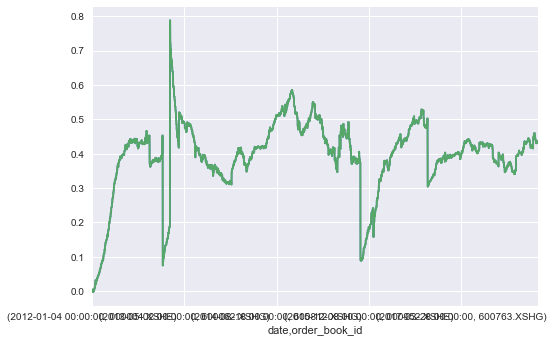

In [50]:
import matplotlib.pyplot as plt
kf_df['market_cap_F'].plot()
plt.show()

Even more unreliable. The factor return for market cap size is highly positive and volatile.

## Conclusion
So, from all the three schemes we have discussed above, we concluded that even though BARRA's risk model has the virtue of simplicity, it is not feasible in interpreting factor returns. Or the regular calibration schemes need amendment.